<ipython-input-5-84b1cefbebc3>:14: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['?'])
<ipython-input-5-84b1cefbebc3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_january_2007['Global_active_power'] = pd.to_numeric(data_january_2007['Global_active_power'], errors='coerce')


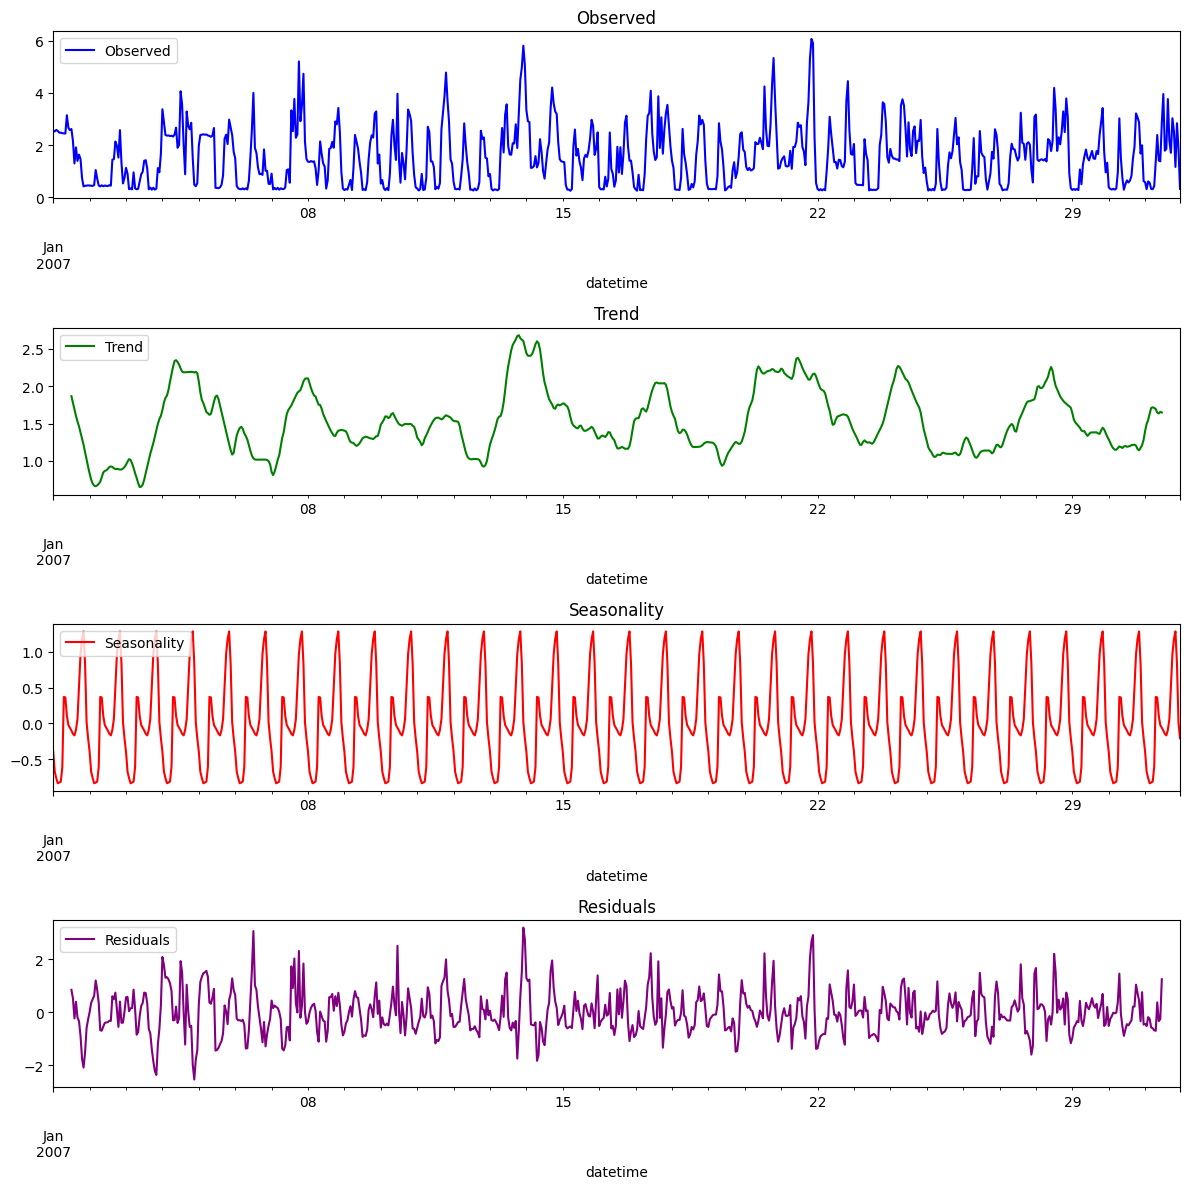

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  744
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 24)   Log Likelihood                -806.892
Date:                             Thu, 27 Jun 2024   AIC                           1625.784
Time:                                     10:30:26   BIC                           1653.456
Sample:                                 01-01-2007   HQIC                          1636.451
                                      - 01-31-2007                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3245      0.066      4.887      0.000       0.194       0.455
ar.L1          0.6942      

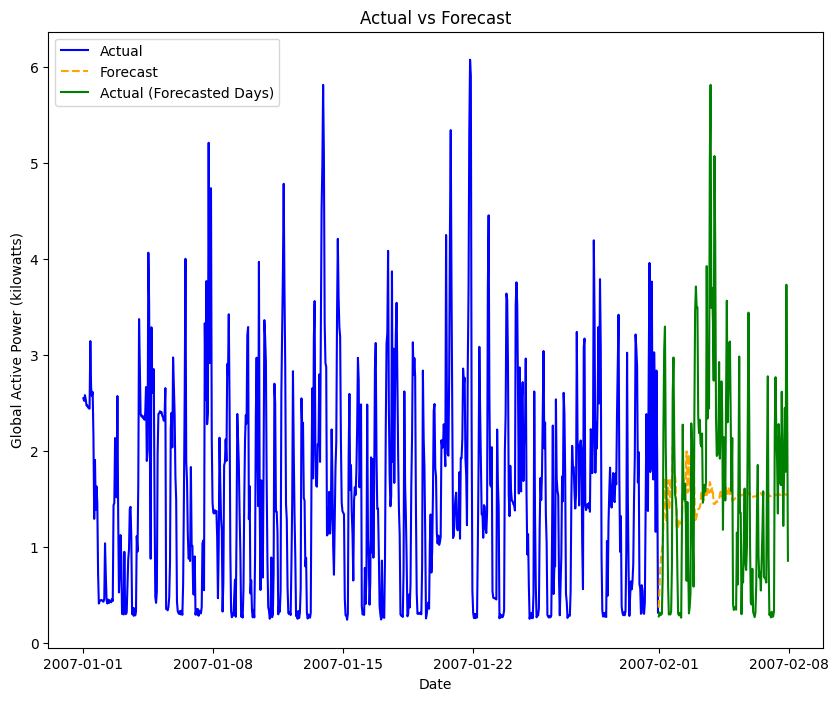

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import warnings

# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the data
file_path = '/content/household_power_consumption[1].txt'
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['?'])

# Convert 'datetime' to datetime format
data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M:%S')

# Set the datetime column as the index
data.set_index('datetime', inplace=True)

# Filter data for January 2007
data_january_2007 = data.loc['2007-01-01':'2007-01-31']

# Ensure that the 'Global_active_power' column is numeric
data_january_2007['Global_active_power'] = pd.to_numeric(data_january_2007['Global_active_power'], errors='coerce')

# Resample the data to hourly mean
data_january_2007_hourly = data_january_2007['Global_active_power'].resample('H').mean()

# Drop NaN values for decomposition
data_january_2007_hourly = data_january_2007_hourly.dropna()



# Decompose the time series
decomposition = seasonal_decompose(data_january_2007_hourly, model='additive')


# Plot the decomposition with improved visualizations
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

decomposition.observed.plot(ax=ax1, color='blue', linestyle='-', label='Observed')
ax1.set_title('Observed')
ax1.legend(loc='upper left')

decomposition.trend.plot(ax=ax2, color='green', linestyle='-', label='Trend')
ax2.set_title('Trend')
ax2.legend(loc='upper left')

decomposition.seasonal.plot(ax=ax3, color='red', linestyle='-', label='Seasonality')
ax3.set_title('Seasonality')
ax3.legend(loc='upper left')

decomposition.resid.plot(ax=ax4, color='purple', linestyle='-', label='Residuals')
ax4.set_title('Residuals')
ax4.legend(loc='upper left')


plt.tight_layout()
plt.show()

# Use auto_arima to find the best model and fit it
model = auto_arima(data_january_2007_hourly, seasonal=True, m=24)
model_fit = model

# Summary of the model
print(model_fit.summary())

# Forecasting function
def forecast_days(model, days):

    # Number of periods to forecast
    periods = days * 24  # hourly data

    # Forecast
    forecast = model.predict(n_periods=periods)

    # Create a datetime index for the forecast
    forecast_index = pd.date_range(start=data_january_2007_hourly.index[-1], periods=periods + 1, freq='H')[1:]

    # Create a DataFrame for the forecast
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])
    return forecast_df


# Forecast for the next 7 days (1 week)
forecast_7_days = forecast_days(model_fit, 7)

# Plot the forecast with actual data
plt.figure(figsize=(10, 8))

# Plot actual data
plt.plot(data_january_2007_hourly, label='Actual', color='blue')

# Plot forecasted values
plt.plot(forecast_7_days, label='Forecast', color='orange', linestyle='--')

# Plot actual data for the forecasted days
actual_forecast_days = data.loc['2007-02-01':'2007-02-07', 'Global_active_power'].resample('H').mean()
plt.plot(actual_forecast_days, label='Actual (Forecasted Days)', color='green')

plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend(loc='upper left')
plt.show()

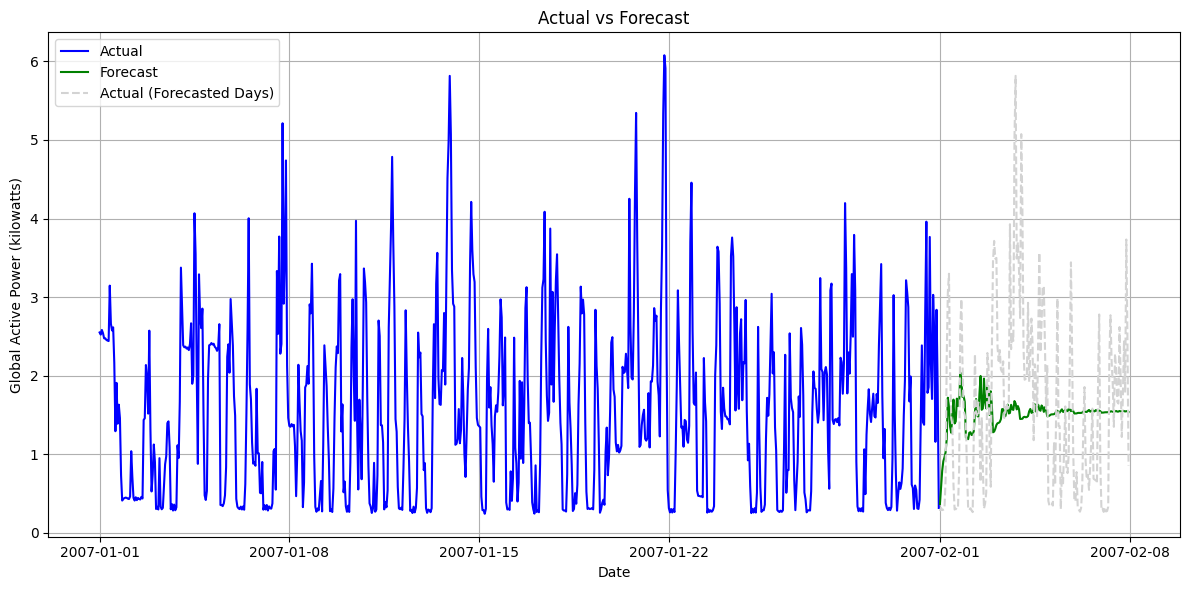

In [ ]:
# Plot the forecast with actual data
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(data_january_2007_hourly.index, data_january_2007_hourly, label='Actual', color='blue')

# Plot forecasted values
plt.plot(forecast_7_days.index, forecast_7_days, label='Forecast', color='green')

# Plot actual data for the forecasted days (dotted light gray lines)
plt.plot(actual_forecast_days.index, actual_forecast_days, label='Actual (Forecasted Days)', color='lightgray', linestyle='--')

plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = '/content/household_power_consumption[1].txt'
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['?'])

# Convert 'datetime' to datetime format
data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M:%S')

# Set the datetime column as the index
data.set_index('datetime', inplace=True)

# Filter data for January 2007
macro_data = data.loc['2007-01-01':'2007-01-31']
print(macro_data.shape)
macro_data.head()

(44640, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


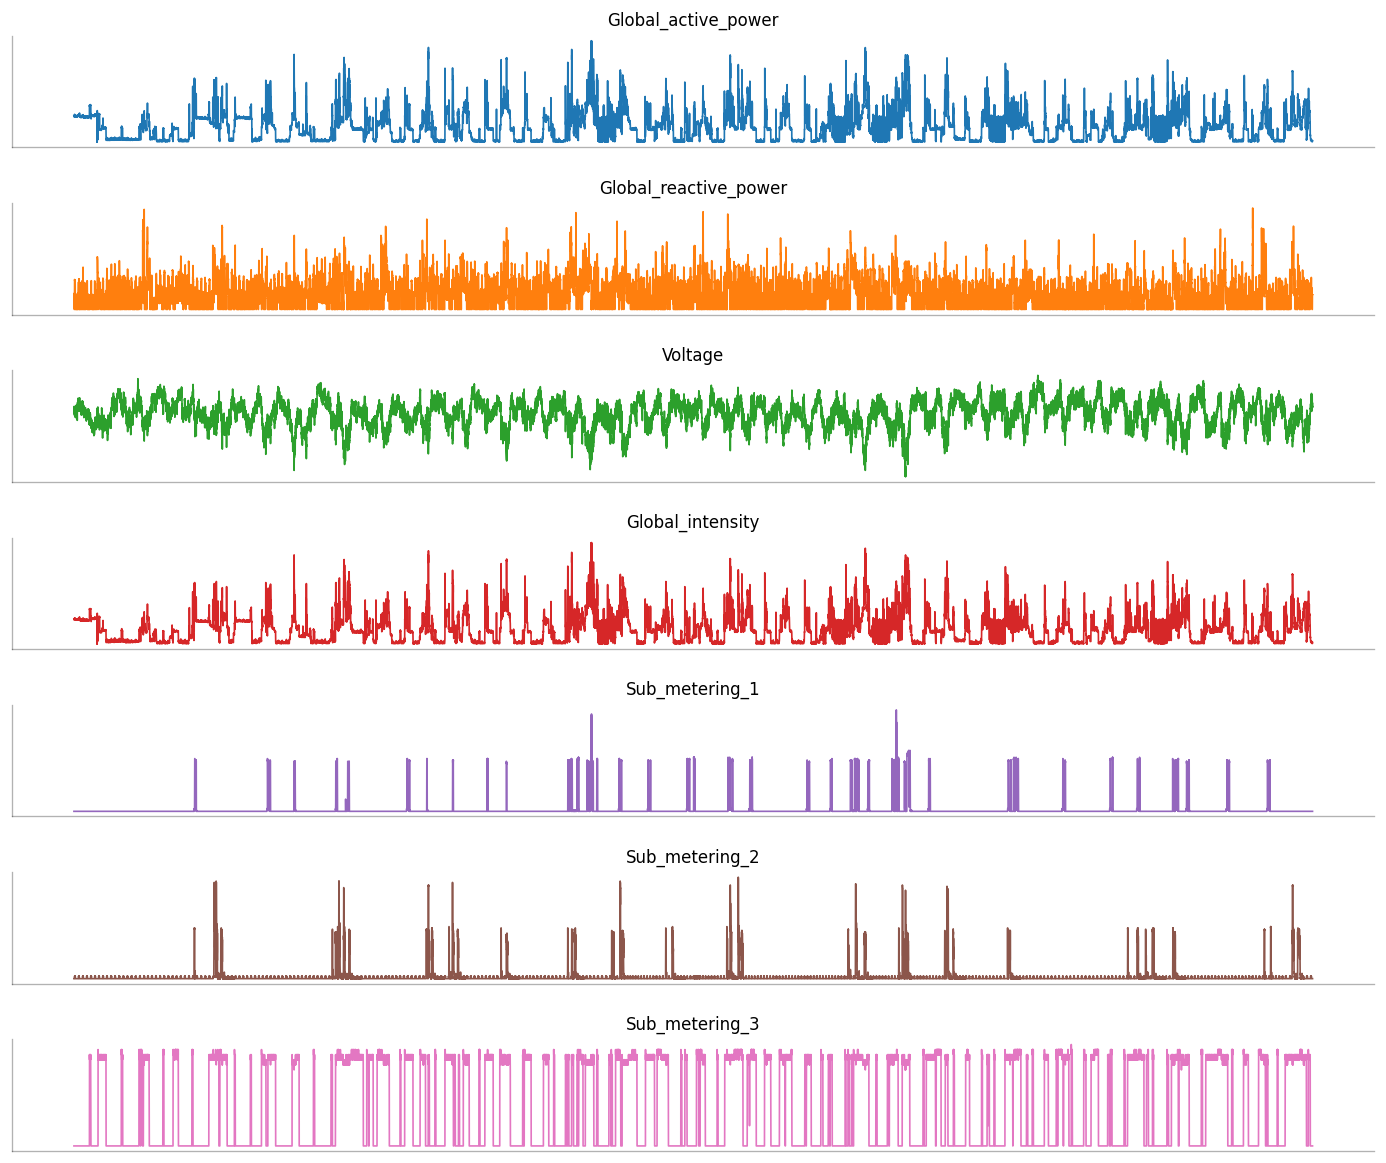

In [ ]:
import numpy as np

# Check for NaN or infinite values
nan_mask = macro_data.isna().any()
inf_mask = np.isinf(macro_data).any()

if nan_mask.any() or inf_mask.any():
    # Handle missing or infinite values
    macro_data = macro_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
    macro_data = macro_data.dropna()  # Drop rows with NaN values

# Proceed with plotting
# Adjusting figure size and arrangement of subplots
num_columns = len(macro_data.columns)
num_rows = (num_columns + 1) // 2  # Round up if odd
fig, axes = plt.subplots(7, ncols=1, dpi=120, figsize=(12, 10))

# Loop to plot each column of data separately
for i, ax in enumerate(axes.flatten()):
    if i < num_columns:  # Ensure there are enough columns for the subplot
        data = macro_data[macro_data.columns[i]]
        ax.plot(data, color='C{}'.format(i), linewidth=1)  # Different color for each line
        # Decorations
        ax.set_title(macro_data.columns[i], fontsize=10)  # Increased title font size
        ax.tick_params(axis='x', labelsize=8)  # Reduced x-axis tick label size
        ax.tick_params(axis='y', labelsize=8)  # Reduced y-axis tick label size
        ax.spines["top"].set_alpha(0)
        ax.spines["right"].set_alpha(0)
        ax.spines["bottom"].set_alpha(0.3)  # Reduced alpha for bottom spine
        ax.spines["left"].set_alpha(0.3)    # Reduced alpha for left spine
    else:
        ax.axis('off')  # Hide the extra subplot

# Adjusting layout and removing ticks
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for ax in axes.flatten():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

plt.show()

In [ ]:
ad_fuller_result_1 = adfuller(macro_data['Global_active_power'])#.diff()[1:])

print('Global_active_power')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['Global_intensity'])#.diff()[1:])

print('Global_intensity')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Global_active_power
ADF Statistic: -11.9641848286817
p-value: 4.036473129214284e-22

---------------------

Global_intensity
ADF Statistic: -12.007580195136134
p-value: 3.2368357690505523e-22


In [ ]:
print('rgnp causes ulc?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['Global_intensity', 'Global_active_power']], 4)

print('\nulc causes rgnp?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['Global_active_power', 'Global_intensity']], 4)

rgnp causes ulc?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9534  , p=0.1622  , df_denom=44634, df_num=1
ssr based chi2 test:   chi2=1.9535  , p=0.1622  , df=1
likelihood ratio test: chi2=1.9535  , p=0.1622  , df=1
parameter F test:         F=1.9534  , p=0.1622  , df_denom=44634, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.4386 , p=0.0000  , df_denom=44631, df_num=2
ssr based chi2 test:   chi2=26.8801 , p=0.0000  , df=2
likelihood ratio test: chi2=26.8720 , p=0.0000  , df=2
parameter F test:         F=13.4386 , p=0.0000  , df_denom=44631, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=19.5905 , p=0.0000  , df_denom=44628, df_num=3
ssr based chi2 test:   chi2=58.7808 , p=0.0000  , df=3
likelihood ratio test: chi2=58.7421 , p=0.0000  , df=3
parameter F test:         F=19.5905 , p=0.0000  , df_denom=44628, df_num=3

Granger Causality
number of lags (no zero) 4

In [ ]:
macro_data = macro_data[['Global_intensity','Global_active_power']]
print(macro_data.shape)

(44638, 2)


In [ ]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [ ]:
print(test_df.shape)

(12, 2)


In [ ]:
model = VAR(train_df.diff()[1:])

In [ ]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.482      -4.481     0.01131      -4.482
1       -4.828      -4.827    0.008000      -4.828
2       -5.032      -5.030    0.006525      -5.032
3       -5.173      -5.171    0.005665      -5.173
4       -5.213      -5.209    0.005447      -5.212
5       -5.240      -5.236    0.005299      -5.239
6       -5.252      -5.247    0.005239      -5.250
7       -5.258      -5.252    0.005206      -5.256
8       -5.274      -5.267    0.005124      -5.272
9       -5.277      -5.269    0.005109      -5.274
10      -5.278      -5.270    0.005102      -5.276
11      -5.280      -5.271    0.005093      -5.277
12      -5.282      -5.273    0.005081      -5.279
13      -5.286      -5.275    0.005064      -5.282
14      -5.289      -5.278    0.005046      -5.286
15      -5.296      -5.283    0.005014      -5.292
16      -5.305      -5.292    0

In [ ]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                        Statespace Model Results                                       
Dep. Variable:     ['Global_intensity', 'Global_active_power']   No. Observations:                44626
Model:                                                  VAR(4)   Log Likelihood               -9991.725
                                                   + intercept   AIC                          20025.450
Date:                                         Thu, 27 Jun 2024   BIC                          20208.277
Time:                                                 11:30:29   HQIC                         20083.024
Sample:                                                      0                                         
                                                       - 44626                                         
Covariance Type:                                           opg                                         
Ljung-Box (L1) (Q):            53.39, 8.84   Jarque-Bera (JB):  

In [ ]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)

predictions=predict.predicted_mean

In [ ]:
predictions.columns=['Global_intensity_predicted','Global_active_power_predicted']
predictions

,Global_intensity_predicted,Global_active_power_predicted
44626,1.167353,0.272171
44627,1.348169,0.314902
44628,1.497425,0.349715
44629,1.593432,0.372794
44630,1.683981,0.394637
44631,1.787488,0.419102
44632,1.903098,0.446491
44633,2.015798,0.473338
44634,2.119796,0.498054
44635,2.217107,0.521140


In [ ]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

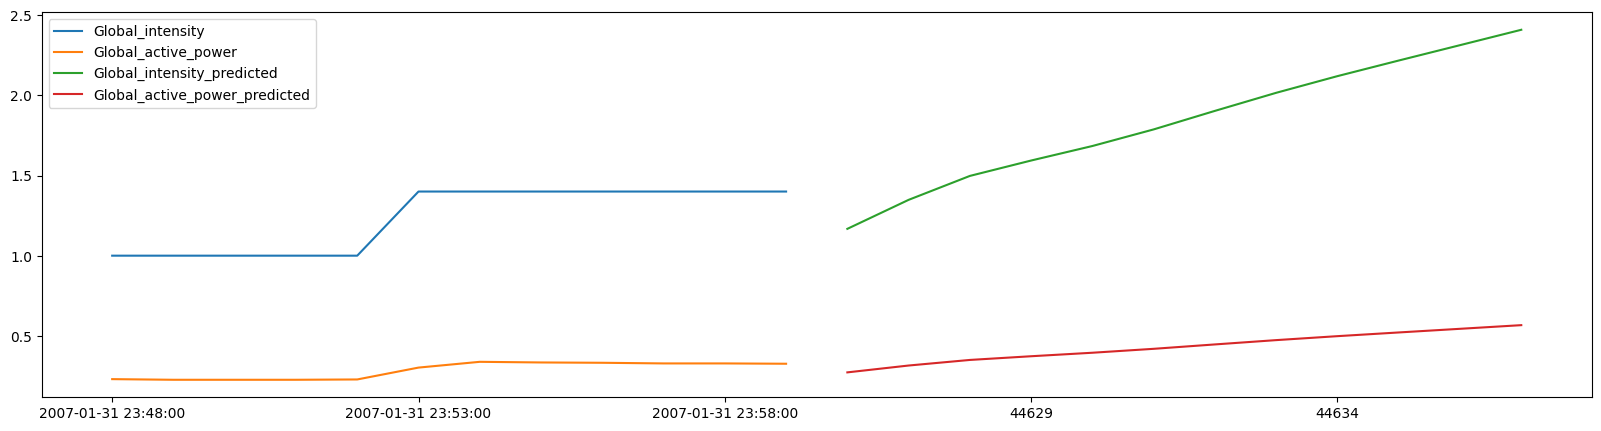

In [ ]:
test_vs_pred.plot(figsize=(20,5))

In [ ]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['Global_intensity_predicted'],test_df['Global_intensity']))
print('Mean value of Global_intensity is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['Global_intensity']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['Global_active_power_predicted'],test_df['Global_active_power']))
print('Mean value of Global_active_power is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['Global_active_power']),rmse_rgnp))

Mean value of Global_intensity is : 1.2333333333333334. Root Mean Squared Error is :0.6478148679422989
Mean value of Global_active_power is : 0.2853333333333333. Root Mean Squared Error is :0.15508131331757635
